In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_WF_1_24_2023'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
subjects.remove('SW4Unfam')

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells150.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS WF 1 24 2023

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results_across_mice_SW_WF_1_24_2023.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results_across_mice_SW_WF_1_24_2023.npy', allow_pickle=True).item()

In [8]:
del dict_results_across_mice['SW4Unfam']

In [9]:
dict_results_across_mice.keys()

dict_keys(['SW12Control', 'SW15Fam', 'SW2Fam', 'SW11Fam', 'SW16Control', 'SW14Unfam', 'SW23Control', 'SW21Control', 'SW22Fam', 'SW17Unfam', 'SW7Unfam', 'SW6Fam', 'SW3Unfam', 'SW8Control', 'SW1Control', 'SW19Fam'])

# List areas with null cell count

In [10]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [11]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [12]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW12Control',
  'SW16Control',
  'SW23Control',
  'SW21Control',
  'SW8Control',
  'SW1Control'],
 'Unfam': ['SW14Unfam', 'SW17Unfam', 'SW7Unfam', 'SW3Unfam'],
 'Fam': ['SW15Fam', 'SW2Fam', 'SW11Fam', 'SW22Fam', 'SW6Fam', 'SW19Fam']}

# Calculate cell count across experimental groups

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [14]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.245411,0.345116,0.987415
1,Primary motor area,0.76571,0.429998,0.569554
2,Secondary motor area,0.797159,0.298087,0.407159
3,Primary somatosensory area,0.739332,0.486613,0.712474
4,Supplemental somatosensory area,0.982775,0.281419,0.354317
...,...,...,...,...
293,Flocculus,0.0428376,0.836618,0.192042
294,Fastigial nucleus,0.558356,0.0831191,0.127537
295,Interposed nucleus,0.055114,0.899779,0.143868
296,Dentate nucleus,0.0501437,0.977317,0.241968


In [15]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [16]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Lateral dorsal nucleus of thalamus,0.00541794
Preparasubthalamic nucleus,0.0141646
Edinger-Westphal nucleus,0.0142149
Globus pallidus internal segment,0.0209215
Periventricular hypothalamic nucleus posterior part,0.021606
Dorsal premammillary nucleus,0.026018
Dorsal nucleus raphe,0.0268238
Medial geniculate complex,0.0275783
Reticular nucleus of the thalamus,0.0283928


In [17]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Area postrema,0.00527611
Supragenual nucleus,0.00624989
Medial preoptic nucleus,0.0113627
Ventral premammillary nucleus,0.0146696
Supramammillary nucleus,0.0230924
Caudoputamen,0.0258622
Subparaventricular zone,0.035502
Dorsal motor nucleus of the vagus nerve,0.0442057
Dorsal premammillary nucleus,0.0455065


In [18]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Lateral habenula,0.0277238
Suprachiasmatic nucleus,0.0307501
Anterodorsal nucleus,0.0326596
Periventricular hypothalamic nucleus preoptic part,0.0429279
Subparaventricular zone,0.0453727
Medial geniculate complex,0.0517229
Medial preoptic nucleus,0.0564299
Anteroventral nucleus of thalamus,0.0619094
Paraflocculus,0.0664985


## Mann Whitney Test for comparison across groups

In [19]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.148553,0.260583,0.374191
1,Primary motor area,0.468093,0.457553,0.457553
2,Secondary motor area,0.468093,0.457553,0.227773
3,Primary somatosensory area,0.468093,0.457553,0.297016
4,Supplemental somatosensory area,0.34446,0.297016,0.168678
...,...,...,...,...
293,Flocculus,0.0460626,0.37456,0.296455
294,Fastigial nucleus,0.260555,0.120477,0.0829033
295,Interposed nucleus,0.0641026,0.457553,0.168678
296,Dentate nucleus,0.0101203,0.334435,0.227773


In [20]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [21]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.00253743
Lateral dorsal nucleus of thalamus,0.00411951
Dorsal premammillary nucleus,0.00653261
Preparasubthalamic nucleus,0.00796829
Periventricular hypothalamic nucleus posterior part,0.0100112
Dentate nucleus,0.0101203
Zona incerta,0.0101203
Ventral part of the lateral geniculate complex,0.0153195
Globus pallidus internal segment,0.0153195


In [22]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Supragenual nucleus,0.00544603
Area postrema,0.0115517
Subparaventricular zone,0.0121517
Nucleus raphe pallidus,0.0128854
Medial preoptic nucleus,0.0214128
Ventral premammillary nucleus,0.0271367
Dorsal motor nucleus of the vagus nerve,0.0315985
Dorsal nucleus raphe,0.0345533
Anteroventral periventricular nucleus,0.0345533


In [23]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Medial geniculate complex,0.0125907
Subparaventricular zone,0.0210985
Anterodorsal nucleus,0.0214128
Lateral habenula,0.0214128
Suprachiasmatic nucleus,0.0267698
Periventricular hypothalamic nucleus preoptic part,0.0271367
Anteroventral periventricular nucleus,0.0345533
Medial preoptic nucleus,0.0349772
Dorsal part of the lateral geniculate complex,0.0549097


## Calculate cross corr across groups per area on cell count

In [24]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

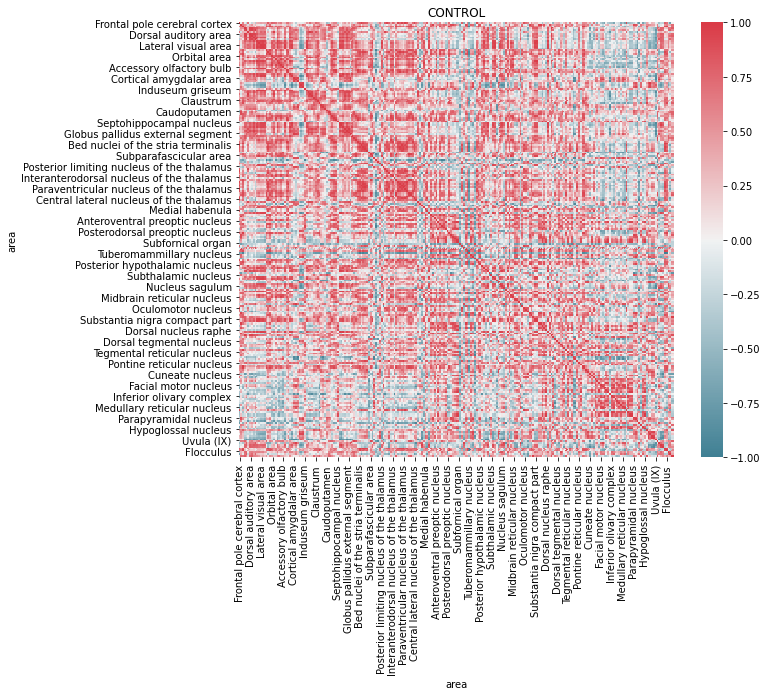

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

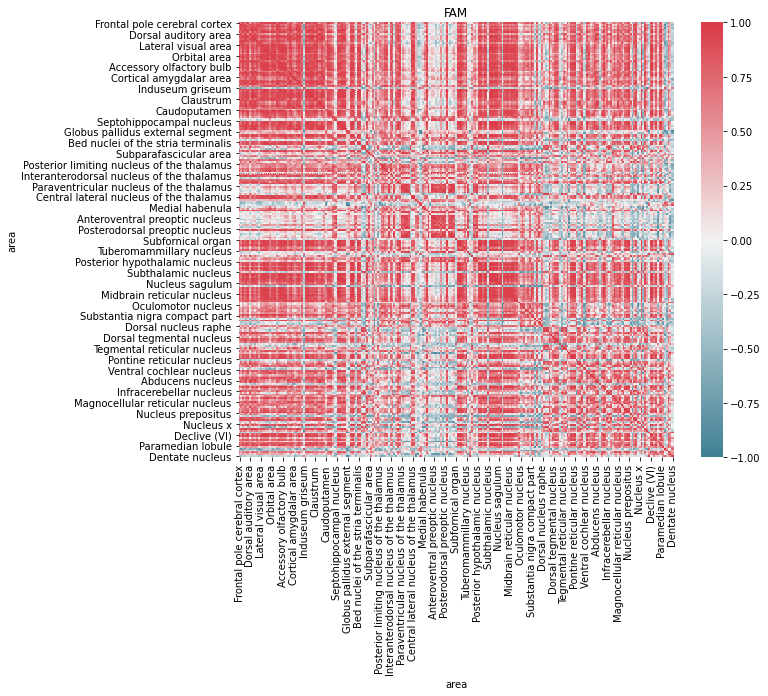

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

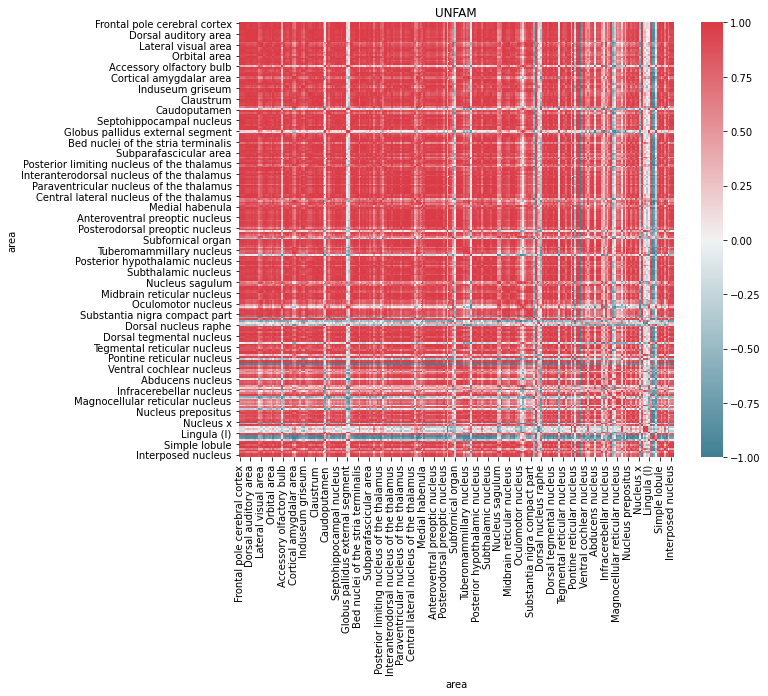

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [28]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [29]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [30]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Lateral dorsal nucleus of thalamus,0.00445341
Reticular nucleus of the thalamus,0.0151406
Edinger-Westphal nucleus,0.0155237
Globus pallidus internal segment,0.0162873
Dorsal premammillary nucleus,0.0183544
Nodulus (X),0.0189624
Dorsal nucleus raphe,0.0220646
Preparasubthalamic nucleus,0.0230939
Supramammillary nucleus,0.038221


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Area postrema,0.00633587
Ventral premammillary nucleus,0.0133546
Medial preoptic nucleus,0.0183931
Supramammillary nucleus,0.0295242
Dorsal premammillary nucleus,0.0327879
Supragenual nucleus,0.0380229
Posterior hypothalamic nucleus,0.0635888
Edinger-Westphal nucleus,0.0642134
Subparaventricular zone,0.0661656


In [33]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal nucleus,0.0184642
Lateral habenula,0.0297672
Suprachiasmatic nucleus,0.0345338
Subparaventricular zone,0.050684
Medial geniculate complex,0.0624982
Medial preoptic nucleus,0.0639354
Periventricular hypothalamic nucleus preoptic part,0.063946
Central lateral nucleus of the thalamus,0.0724362
Lateral dorsal nucleus of thalamus,0.0752207


## Mann-Whitney Test across groups

In [34]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [35]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Superior salivatory nucleus,0.00253743
Substantia nigra lateral part,0.00253743
Granular lamina of the cochlear nuclei,0.00253743
Cochlear nucleus subpedunclular granular region,0.00253743
Nucleus z,0.00253743
Accessory abducens nucleus,0.00253743
Efferent vestibular nucleus,0.00253743
Intercollicular nucleus,0.00253743
Efferent cochlear group,0.00253743


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Supragenual nucleus,0.00570861
Accessory abducens nucleus,0.00710702
Efferent cochlear group,0.00710702
Suprachiasmatic preoptic nucleus,0.00710702
Efferent vestibular nucleus,0.00710702
Lobule IV,0.00710702
Substantia nigra lateral part,0.00710702
Nucleus intercalatus,0.00710702
Nucleus z,0.00710702


In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Interstitial nucleus of the vestibular nerve,0.00253743
Lobule IV,0.00253743
Lobule V,0.00253743
Nucleus intercalatus,0.00253743
Paramedian reticular nucleus,0.00253743
Superior salivatory nucleus,0.00253743
Pineal body,0.00253743
Nucleus circularis,0.00253743
Lateral strip of striatum,0.00253743


## Calculate cross corr matrix across experimental groups on energy

In [39]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

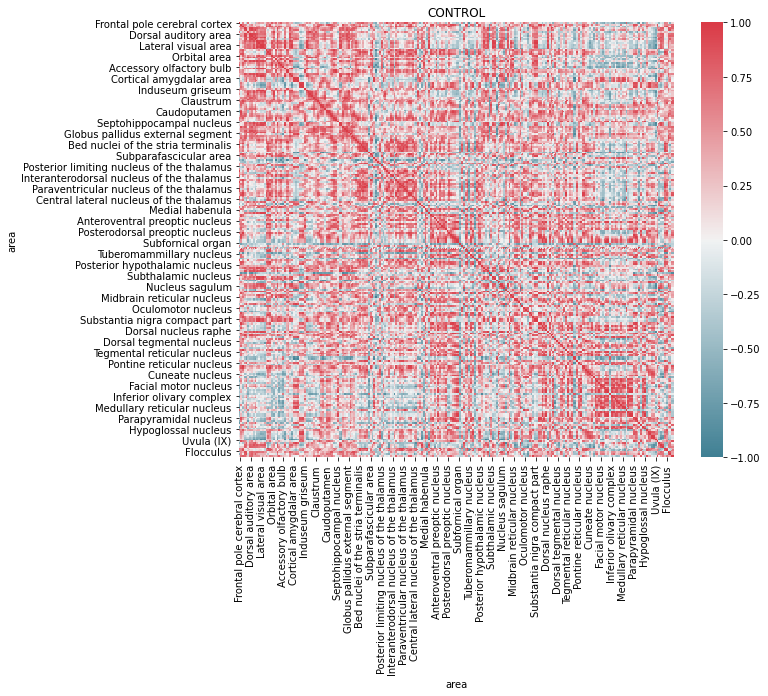

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

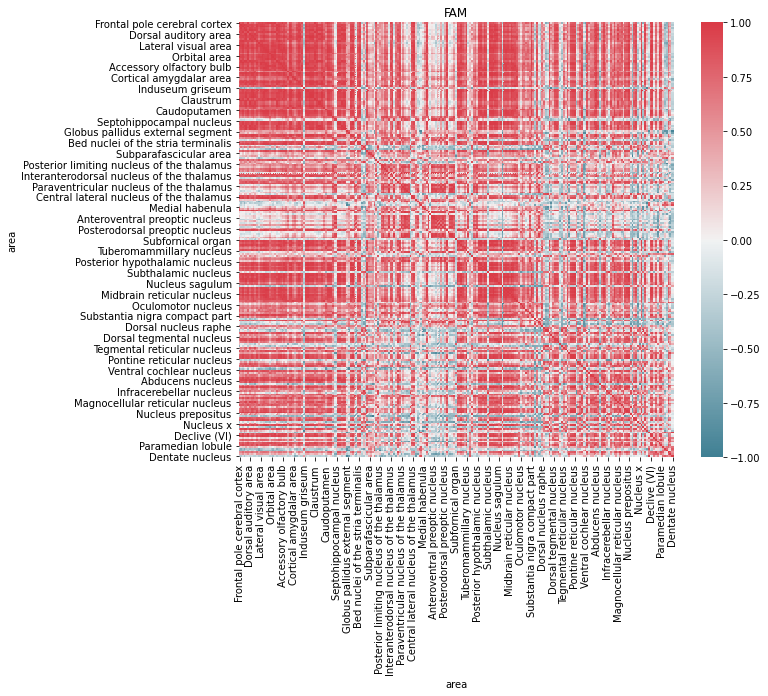

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

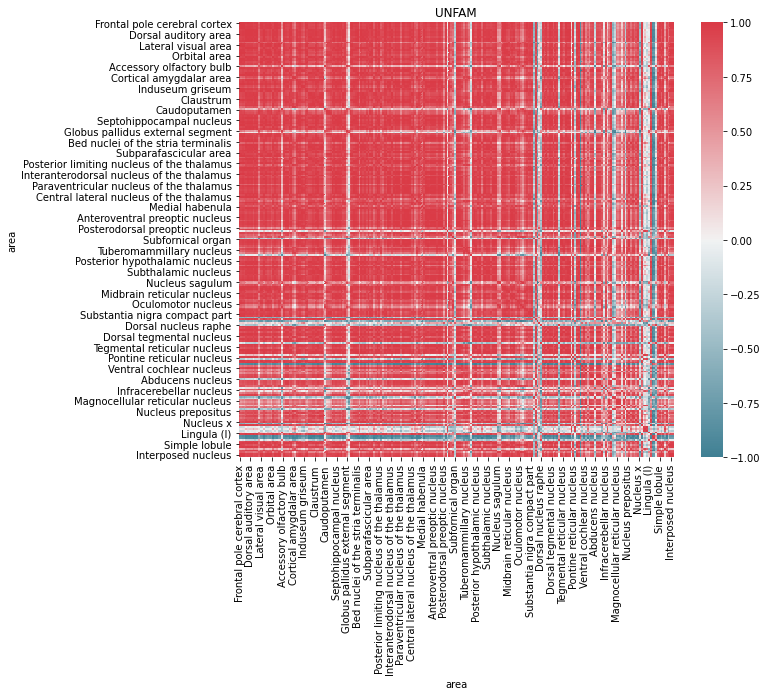

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')